# Sound classification with convolutional networks and fast ai
This is an example of how easy it is to get great results quickly with the new fastai library.

We will attempt a 10 class sound classification problem: [urbansound8k](https://urbansounddataset.weebly.com/urbansound8k.html)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.

We will convert the audio files to spectrogram images and then classify with fastai's vision learner.

# Download and extract audio data

In [ ]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

In [2]:
!ls UrbanSound8K/audio/

fold1  fold10  fold2  fold3  fold4  fold5  fold6  fold7  fold8	fold9


The folder structure contains 10 predefined validation folds.
According to the creators of the data set, you should evaluate with the provided folds and not reshuffle.

"Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores
We have seen reports that only provide results for a single train/test split, e.g. train on folds 1-9, test on fold 10 and report a single accuracy score. We strongly advise against this. Instead, perform 10-fold cross validation using the provided folds and report the average score.

Why?
Not all the splits are as "easy". That is, models tend to obtain much higher scores when trained on folds 1-9 and tested on fold 10, compared to (e.g.) training on folds 2-10 and testing on fold 1. For this reason, it is important to evaluate your model on each of the 10 splits and report the average accuracy.
Again, your results will NOT be comparable to previous results in the literature."

Let's listen to a sound

In [3]:
import IPython
IPython.display.Audio("UrbanSound8K/audio/fold1/26270-9-0-35.wav")

All audio samples are 4 seconds long which fits well with our spectrogram method.

# Process the data and create spectrograms

In [11]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [9]:
!mkdir 'UrbanSound8K/spectrogram'

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [ ]:
for i in range(1, 11):
    create_fold_spectrograms(str(i))

Create ImageNet style directory structure for each of the folds for easy data loading

In [15]:
!mkdir 'UrbanSound8K/data'

In [25]:
import os
import glob
import shutil
from pathlib import Path  
data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')  
def create_fold_directory(fold):
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name) 

In [26]:
for i in range(1, 11):
    create_fold_directory(str(i))

First let's take a look at some of the data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
data_directory = Path('UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
data.normalize(imagenet_stats)    

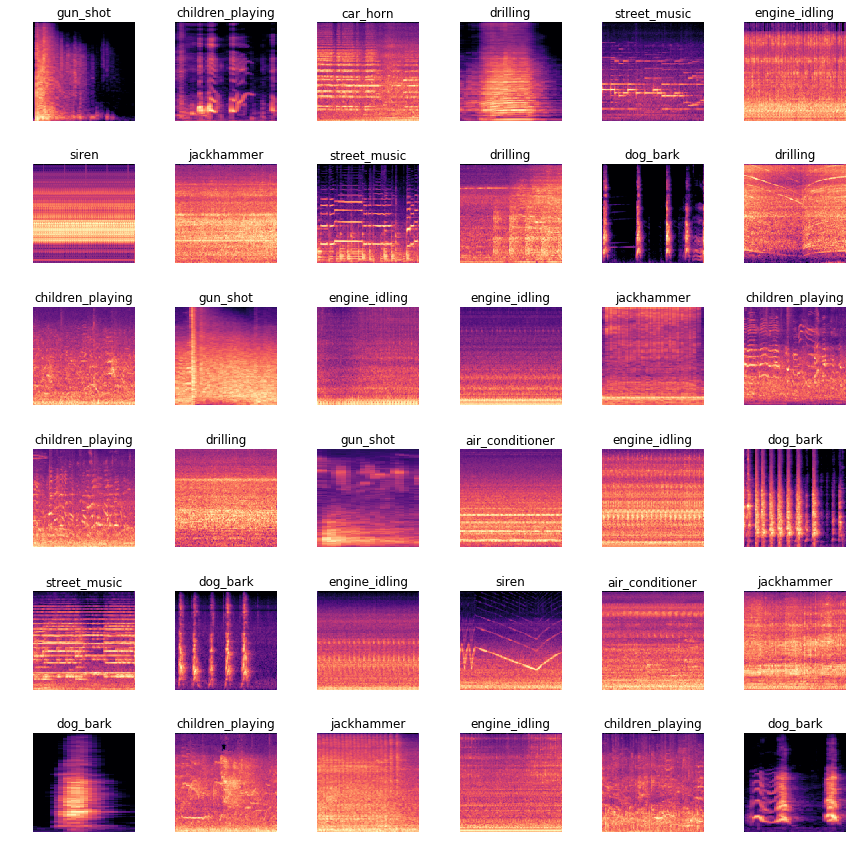

In [29]:
data.show_batch(rows=6, figsize=(12,12))

In [4]:
def process_fold(fold):
    data_directory = Path('UrbanSound8K/data')
    data = ImageDataBunch.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = ConvLearner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [33]:
process_fold('1')

Total time: 02:43
epoch  train loss  valid loss  error_rate
1      0.993585    0.770925    0.277205    (00:54)
2      0.510835    0.670646    0.230241    (00:54)
3      0.323614    0.665087    0.229095    (00:54)



Total time: 01:19
epoch  train loss  valid loss  error_rate
1      0.459794    0.922590    0.229095    (01:19)



Total time: 03:53
epoch  train loss  valid loss  error_rate
1      0.197011    0.923639    0.234822    (01:17)
2      0.158350    0.981821    0.233677    (01:17)
3      0.141122    0.986835    0.231386    (01:17)



In [34]:
process_fold('2')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.979263    1.178866    0.377252    (00:56)
2      0.507712    1.078393    0.313063    (00:54)
3      0.294632    1.085833    0.298423    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.451498    0.812663    0.268018    (01:18)



Total time: 03:53
epoch  train loss  valid loss  error_rate
1      0.202659    0.746880    0.207207    (01:17)
2      0.166748    0.759948    0.197072    (01:17)
3      0.140186    0.755732    0.217342    (01:17)



In [35]:
process_fold('3')

Total time: 02:44
epoch  train loss  valid loss  error_rate
1      0.961428    1.042998    0.358919    (00:55)
2      0.508866    0.897178    0.299459    (00:54)
3      0.313719    0.799877    0.282162    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.427868    0.862156    0.284324    (01:18)



Total time: 03:52
epoch  train loss  valid loss  error_rate
1      0.190932    0.791063    0.261622    (01:17)
2      0.158912    0.796889    0.245405    (01:17)
3      0.135586    0.823703    0.258378    (01:17)



In [36]:
process_fold('4')

Total time: 02:42
epoch  train loss  valid loss  error_rate
1      0.976675    0.957877    0.334343    (00:54)
2      0.521528    0.856860    0.292929    (00:53)
3      0.317314    0.802957    0.270707    (00:53)



Total time: 01:16
epoch  train loss  valid loss  error_rate
1      0.452317    0.624412    0.233333    (01:16)



Total time: 03:50
epoch  train loss  valid loss  error_rate
1      0.220860    0.545379    0.202020    (01:17)
2      0.188691    0.509812    0.175758    (01:16)
3      0.151557    0.497333    0.168687    (01:17)



In [37]:
process_fold('5')

Total time: 02:44
epoch  train loss  valid loss  error_rate
1      0.999826    0.641723    0.204060    (00:56)
2      0.514000    0.469142    0.157051    (00:54)
3      0.320578    0.466936    0.154915    (00:54)



Total time: 01:17
epoch  train loss  valid loss  error_rate
1      0.463455    0.380800    0.117521    (01:17)



Total time: 03:52
epoch  train loss  valid loss  error_rate
1      0.208799    0.352814    0.123932    (01:17)
2      0.167225    0.331026    0.116453    (01:17)
3      0.135377    0.329626    0.111111    (01:17)



In [38]:
process_fold('6')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.994615    1.052073    0.312272    (00:56)
2      0.521276    1.048978    0.269745    (00:54)
3      0.312614    0.999313    0.253949    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.395405    0.661620    0.233293    (01:18)



Total time: 03:54
epoch  train loss  valid loss  error_rate
1      0.182123    0.581981    0.211422    (01:18)
2      0.146056    0.593371    0.201701    (01:18)
3      0.124248    0.609389    0.191981    (01:18)



In [39]:
process_fold('7')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.982167    0.938723    0.319809    (00:56)
2      0.521412    0.874878    0.254177    (00:54)
3      0.300748    0.913296    0.252983    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.406876    0.711222    0.242243    (01:18)



Total time: 03:54
epoch  train loss  valid loss  error_rate
1      0.212976    0.669471    0.227924    (01:18)
2      0.168786    0.691459    0.229117    (01:18)
3      0.137955    0.681417    0.232697    (01:18)



In [40]:
process_fold('8')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.957642    1.232412    0.353598    (00:56)
2      0.511239    1.249228    0.322581    (00:54)
3      0.311715    1.179185    0.296526    (00:54)



Total time: 01:19
epoch  train loss  valid loss  error_rate
1      0.422739    0.952523    0.290323    (01:19)



Total time: 03:54
epoch  train loss  valid loss  error_rate
1      0.191517    0.899117    0.270471    (01:18)
2      0.154842    0.920882    0.259305    (01:18)
3      0.129181    0.882196    0.255583    (01:18)



In [41]:
process_fold('9')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.954791    0.908960    0.270833    (00:56)
2      0.490632    0.805734    0.216912    (00:54)
3      0.298276    0.778905    0.204657    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.456883    0.518055    0.143382    (01:18)



Total time: 03:54
epoch  train loss  valid loss  error_rate
1      0.215399    0.523232    0.139706    (01:18)
2      0.165087    0.489797    0.127451    (01:18)
3      0.143068    0.526157    0.134804    (01:18)



In [42]:
process_fold('10')

Total time: 02:45
epoch  train loss  valid loss  error_rate
1      0.963422    0.842718    0.243728    (00:56)
2      0.499990    0.862057    0.232975    (00:54)
3      0.316690    0.816372    0.227001    (00:54)



Total time: 01:18
epoch  train loss  valid loss  error_rate
1      0.439856    0.541891    0.170848    (01:18)



Total time: 03:53
epoch  train loss  valid loss  error_rate
1      0.207594    0.535445    0.164875    (01:18)
2      0.164575    0.552940    0.150538    (01:17)
3      0.131274    0.535217    0.150538    (01:17)



In [2]:
1-0.1*(0.231+0.217+0.258+0.168+0.111+0.191+0.232+0.255+0.134+0.150)

0.8053

# We now have a mean accuracy across the 10 folds of *80.5%*

According to the latest [publication](https://arxiv.org/abs/1608.04363) on the [dataset's](https://urbansounddataset.weebly.com/publications.html) website, the state-of-the-art mean accuracy  achieved was 79%. It should be noted that is with extensive audio specific augmentation, and without augmentation their top accuracy was 74%.


It's pretty cool that fastai out-of-the-box can produce these kind of results even on images distant from the kind found in ImageNet!